** Zhiyu Fu **

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import mean_squared_error

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
np.random.seed(1)

In [3]:
bd = pd.read_csv("biden.csv")
bd.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [4]:
bd.shape

(1807, 6)

# a) Fitting the tree with default parameters

In [5]:
X_train, X_test, y_train, y_test = train_test_split(bd.iloc[:,1:], bd.biden, test_size = .3,
                                                    random_state=25)

In [6]:
tree1 = DecisionTreeRegressor(random_state= 1)
tree1.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [7]:
tree1_viz = export_graphviz(
    tree1,
    out_file=None,
    feature_names=X_train.columns,
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)
graph = graphviz.Source(tree1_viz)
graph.render('tree1_viz')
graph

In [8]:
y_pred = tree1.predict(X_test)
mean_squared_error(y_test, y_pred)

687.63796103155812

The decision rule can be seen in the graph, which is long and complicated and hence not very interpretable. For viewing the graph in detail, see "tree_viz.pdf" in the same folder.

This estimator achieves an MSE of 712.65.

# b) Searching the best parameters

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
tuned_parameters = [{
    'max_depth': [2, 3, 4, 5],
    'max_features': [2, 3, 4, 5],
    'min_samples_split': [x for x in range(2, 30, 2)]}
]


clf = GridSearchCV(DecisionTreeRegressor(random_state= 1), tuned_parameters, cv = 5, scoring = "neg_mean_squared_error")
clf.fit(X_train,  y_train)
print(clf.best_params_)
y_pred2 = clf.predict(X_test)
mean_squared_error(y_test, y_pred2)

{'max_depth': 2, 'max_features': 5, 'min_samples_split': 2}


400.06539818418173

The best parameter obtained through cross validation is as above. This estimator achieves an MSE of 400.065, which is much lower than the first one. 

Pruning the tree significantly improves the test MSE.

The optimal tree can be seen below.

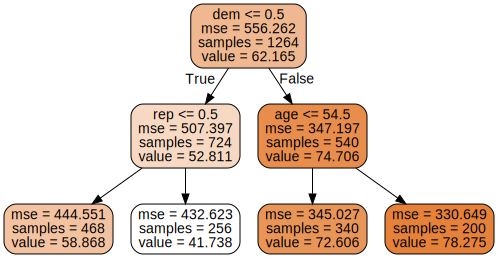

In [11]:
tree2 = DecisionTreeRegressor(*clf.best_params_)

tree2_viz = export_graphviz(
    clf.best_estimator_,
    out_file=None,
    feature_names=X_train.columns,
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)
graph = graphviz.Source(tree2_viz)
graph.render('tree2_viz')
graph

# c) Bagging Approach

In [12]:
from sklearn.ensemble import BaggingRegressor

In [13]:
X, y = bd.iloc[:,1:].values, bd.biden.values
bag = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=1)
bag.fit(X, y)
y_pred3 = bag.oob_prediction_
mean_squared_error(y, y_pred3)

406.06475130169548

In [14]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)

fi = pd.DataFrame(feature_importances.reshape((1, 5)), columns = bd.columns[1:])
fi

,female,age,educ,dem,rep
0,0.065566,0.437207,0.203769,0.183009,0.110449


Age plays the most important role in prediction, followed by education and political tendency. Gender has the least importance.

# d) Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
forest1 = RandomForestRegressor(n_estimators=100, max_features=1, bootstrap=True,
                                  oob_score=True, random_state=1)
forest1.fit(X, y)
y_pred4_1 = forest1.oob_prediction_


forest2 = RandomForestRegressor(n_estimators=100, max_features=2, bootstrap=True,
                                  oob_score=True, random_state=1)
forest2.fit(X, y)
y_pred4_2 = forest2.oob_prediction_

forest3 = RandomForestRegressor(n_estimators=100, max_features=3, bootstrap=True,
                                  oob_score=True, random_state=1)
forest3.fit(X, y)
y_pred4_3 = forest3.oob_prediction_

In [17]:
mses = pd.DataFrame(np.array([
mean_squared_error(y, y_pred4_1),
mean_squared_error(y, y_pred4_2),
mean_squared_error(y, y_pred4_3)    
]).reshape((1, 3)), columns = ["m = 1", 'm = 2', 'm = 3'])
mses


,m = 1,m = 2,m = 3
0,541.865354,543.126041,538.024528


The MSE for each model are as above.

Random forest model achieves best performance with $m = 3$, followed by $m = 1$. $m = 2$ has the worst predictive power. The difference of MSE is small but consistent across different seeds for random state.